In [1]:
import pyspark

In [2]:
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
from pyspark.sql import SQLContext
sqlCtx = SQLContext(sc)
db = sqlCtx.read.format("jdbc").options(url ="jdbc:sqlite:/Users/eshna/BigDataProject/tweets.db", driver="org.sqlite.JDBC", dbtable="tesla").load()

In [3]:
db.show()

+---------------+---------+--------------------+--------------------+---------+
|       username|followers|               tweet|         tweet_clean|sentiment|
+---------------+---------+--------------------+--------------------+---------+
|      TeslaBumm|      0.0|I have some extra...|I have some extra...|  neutral|
| teslamodel3fan|   5612.0|Wanted to share #...|Wanted to share  ...| positive|
|  CaptainMorg10|    377.0|RT @MrGraphite2: ...| Big end of town ...|  neutral|
|     AcvGateway|    110.0|RT @Paula_Piccard...| Tesla's Full Sel...|  neutral|
|   pokeyrosie02|   5955.0|RT @DIXIEDOODLE12...| Hitler's bodygrd...|  neutral|
|       TNR_Gold|   2636.0|RT @kirillklip: T...| Thank you! Our  ...| positive|
|       teahyyng|   1430.0|Video 15 seconds ...|Video 15 seconds ...|  neutral|
|       FRCTeams|  27452.0|Be sure to stop b...|Be sure to stop b...| positive|
|      CityByrne|   1246.0|Can #Tesla delive...|Can  deliver a fl...|  neutral|
|   RicksSoSlick|    737.0|RT @FullofCen

In [4]:
# Creating table 
db.createOrReplaceTempView("tesla") 

In [5]:
# Count of Sentiment 
sent_count = spark.sql("select sentiment, count(sentiment) as count from tesla group by sentiment")
sent_count.show()

+---------+-----+
|sentiment|count|
+---------+-----+
| positive|  278|
|  neutral|  164|
| negative|  239|
+---------+-----+



# Distribution of Tweets

In [6]:
# Making Plots 
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np

sentimentCount_tuple = sent_count.rdd.map(lambda p: tuple(p)).collect()
sentiment_list, count_list = zip(*sentimentCount_tuple)
sentimentCount_tuple

[('positive', 278), ('neutral', 164), ('negative', 239)]

Text(0.5, 1.0, 'Distribution of tweets')

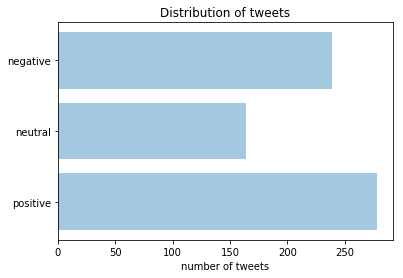

In [7]:
y_pos = np.arange(len(sentiment_list))
plt.barh(y_pos, count_list, align='center', alpha = 0.4)
plt.yticks(y_pos, sentiment_list)
plt.xlabel("number of tweets")
plt.title("Distribution of tweets")

# Tweet type distribution by Sentiment

In [8]:
# classifying tweets as original and retweet 
from pyspark.sql.functions import lit
tweet_type_original = spark.sql("select sentiment from tesla where tweet not like 'RT%'")
tweet_type = tweet_type_original.withColumn("tweet_typ", lit("ORI"))

tweet_type_rt = spark.sql("select sentiment from tesla where tweet like 'RT%'")
tweet_type = tweet_type.union(tweet_type_rt.withColumn("tweet_typ", lit("RT")))

tweet_CrossTab = tweet_type.stat.crosstab("sentiment", "tweet_typ")
tweet_CrossTab.show()

+-------------------+---+---+
|sentiment_tweet_typ|ORI| RT|
+-------------------+---+---+
|            neutral| 69| 95|
|           positive|141|137|
|           negative| 32|207|
+-------------------+---+---+



In [9]:
# Plotting the stacked bar chart. 
tweetType_tuple = tweet_CrossTab.rdd.map(lambda p: tuple(p)).collect()
sentiment_list, ori_list, rt_list = zip(*tweetType_tuple)
tweetType_tuple

[('neutral', 69, 95), ('positive', 141, 137), ('negative', 32, 207)]

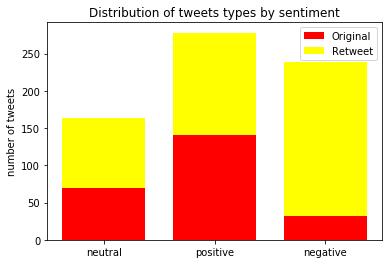

In [10]:
y_pos = np.arange(len(sentiment_list))
p1 = plt.bar(y_pos, ori_list, width = 0.75, color = 'red')
p2 = plt.bar(y_pos, rt_list, width = 0.75, color = 'yellow', bottom = ori_list)
plt.xticks(y_pos, sentiment_list, )
plt.ylabel("number of tweets")
plt.title("Distribution of tweets types by sentiment")
plt.legend((p1[0], p2[0]), ('Original', 'Retweet'))

# Top 10 Popular Users, who are tweeting negatively 


In [11]:
follower_count = spark.sql("select distinct username, followers, tweet_clean from tesla where sentiment = 'negative' and tweet not like 'RT%' order by followers DESC limit 10").show(10, False)

+---------------+---------+-----------------------------------------------------------------------------------------------------------------+
|username       |followers|tweet_clean                                                                                                      |
+---------------+---------+-----------------------------------------------------------------------------------------------------------------+
|TeslaMotorsClub|108966.0 |Tesla Posts Big Q1 Loss, Says Expect the Same Next Quarter                                                       |
|haroldlgardner |25915.0  | Posts Big  as Its  Sales Lag                                                                                    |
|danilefer      |2916.0   |fegeret: Elon Musk is annoying the hell out of people who work with self-driving cars                            |
|fegeret        |2709.0   |Elon Musk is annoying the hell out of people who work with self-driving cars                                     |
|mnaEN

# Most Re-Tweeted negative comment 

In [12]:
retweet_text= spark.sql("select tweet, count(tweet) as ct from tesla where tweet like 'RT%'and sentiment = 'negative' group by tweet order by count(tweet) DESC limit 1")
retweet_text.show(20,False)

+----------------------------------------------------------------------------------------------------------------------------------------------+---+
|tweet                                                                                                                                         |ct |
+----------------------------------------------------------------------------------------------------------------------------------------------+---+
|RT @Scotty49er: So today I drove a Tesla for the first time, and now all other cars are ruined for me. Our current gas car now feels like a...|168|
+----------------------------------------------------------------------------------------------------------------------------------------------+---+



In [13]:
# top 10 negative tweeters with large follower counts
spark.sql("select distinct username, followers from tesla where sentiment = 'negative' order by followers DESC limit 10" ).show()

+---------------+---------+
|       username|followers|
+---------------+---------+
|TeslaMotorsClub| 108966.0|
| SpirosMargaris|  75379.0|
| haroldlgardner|  25915.0|
|    Luminaria98|   6852.0|
|  Green_Living1|   5089.0|
|   KlendathuCap|   4423.0|
|  ZarieOfficial|   3900.0|
|FlatJannrickles|   3300.0|
|aricrindfleisch|   2939.0|
|      danilefer|   2916.0|
+---------------+---------+



In [14]:
# tweets that are not retweets, but original tweets. 
original_tweets = spark.sql("select * from tesla where tweet not like 'RT%'")
original_tweets.groupBy("sentiment")\
          .count() \
          .show()

+---------+-----+
|sentiment|count|
+---------+-----+
| positive|  141|
|  neutral|   69|
| negative|   32|
+---------+-----+



In [15]:
original_tweets.createOrReplaceTempView("ori_tweet")

In [16]:
# Display the most popular users who post negative tweets.  
spark.sql("select distinct username, followers, tweet from ori_tweet where sentiment = 'negative' order by followers DESC limit 10" ).show(20, False)

+---------------+---------+----------------------------------------------------------------------------------------------------------------------------------------------+
|username       |followers|tweet                                                                                                                                         |
+---------------+---------+----------------------------------------------------------------------------------------------------------------------------------------------+
|TeslaMotorsClub|108966.0 |Tesla Posts Big Q1 Loss, Says Expect the Same Next Quarter #Tesla #TSLA https://t.co/N3HBO63RQa                                               |
|haroldlgardner |25915.0  |#Tesla Posts Big #QuarterlyLoss as Its #ElectricCar Sales Lag https://t.co/qDnWPJOo4o #ElonMusk #ElectricVehicles... https://t.co/IxCqJdOonP  |
|danilefer      |2916.0   |fegeret: Elon Musk is annoying the hell out of people who work with self-driving cars #AutonomousVehicles #Tesla... ht